In [1]:
# https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [2]:
!pip install -U scikit-image
!pip install -U miplib

# 3D Plotting
'''
!pip install mayavi
!pip install PyQt5
!jupyter nbextension install --py mayavi --user
!jupyter nbextension enable --py mayavi --user
'''

Requirement already up-to-date: scikit-image in ./miniconda3/envs/thesis/lib/python3.7/site-packages (0.18.1)
Requirement already up-to-date: miplib in ./miniconda3/envs/thesis/lib/python3.7/site-packages (1.0.6)


'\n!pip install mayavi\n!pip install PyQt5\n!jupyter nbextension install --py mayavi --user\n!jupyter nbextension enable --py mayavi --user\n'

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import scipy

import time
import gc

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [7]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

--2021-04-02 00:46:54--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
           => ‘emd_30458.map.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-30458/map ... done.
==> SIZE emd_30458.map.gz ... 5219344
==> PASV ... done.    ==> RETR emd_30458.map.gz ... done.
Length: 5219344 (5.0M) (unauthoritative)

emd_30458.map.gz    100%[===================>]   4.98M  5.57MB/s    in 0.9s    

2021-04-02 00:46:57 (5.57 MB/s) - ‘emd_30458.map.gz’ saved [5219344]



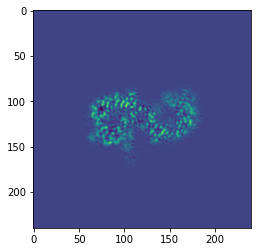

In [5]:
create_structure_from_scratch = True

if create_structure_from_scratch: 
    # Getting test rNLRP1-rDPP9 map
    map_filename = 'emd_30458.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_30458.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_30458.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)
    plt.imshow(raw_structure[:, :, raw_structure.shape[0] // 2])
    
    structure = np.expand_dims(raw_structure, axis=-1)
    # structure = structure[50:-50, 50:-50, 50:-50, :]
    # structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))
    
    # with open('rNLRP1-rDPP9_original_structure_reduced.npy', 'wb') as f:
    #     np.save(f, structure)
else:
    structure = np.load('rNLRP1-rDPP9_original_structure_reduced.npy')

px_to_A = 1.06 # TRPV1 dataset specific

In [8]:
siren_model = torch.load('rNLRP1-rDPP9_siren_model.pt')
siren_model.eval();

In [9]:
from IPython.display import clear_output

In [10]:
desired_shape = structure.shape[0]

input_coords = get_mgrid(desired_shape, 3)
dataloader = DataLoader(input_coords, batch_size=1024, pin_memory=True, num_workers=0)

all_coords = []
all_densities = []

num_processed = 0
num_input = 0
for batch, model_input in enumerate(dataloader):
    clear_output()
    print(batch, '/', len(dataloader))
    
    model_input = model_input.cuda()
    
    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    # all_coords.append(model_input.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())
    num_processed += len(model_output.cpu().detach().numpy().squeeze())
    num_input += len(model_input)
    
all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, desired_shape - 1, desired_shape)])), axis=-1).reshape(-1, 3).astype(int)

all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

final_siren_output = np.zeros((desired_shape, desired_shape, desired_shape))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

13499 / 13500


In [11]:
plt.imshow(structure[:, desired_shape // 2, :])

In [12]:
plt.imshow(final_siren_output[:, desired_shape // 2, :])

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


Resolution: 6.178285714285714


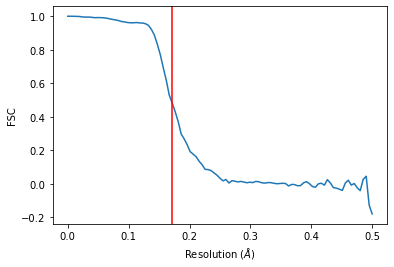

In [13]:
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions

# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

# FSC_vals *= -1 # Remove later

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
# ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0]]
    ax.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
    print("Resolution:", resolution)
# ax.set_xlabel('Frequency (1/px)')
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.show()